In [274]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

## Import data set of 20 newsgroups

In [45]:
from sklearn.datasets import fetch_20newsgroups


In [222]:
groups=fetch_20newsgroups(subset='all',categories=['alt.atheism','talk.religion.misc','comp.graphics','sci.space'])

In [132]:
labels = groups.target

In [133]:
label_names = groups.target_names

## Import NLTK

In [ ]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

In [44]:
all_names = set(names.words())

In [46]:
lemmatizer = WordNetLemmatizer()

## clean data: lower, retain only alphabet, remove names, lemmatize

In [135]:
data_cleaned=[]
for doc in groups.data:
    doc=doc.lower()
    doc_cleaned=' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word.isalpha() and word not in all_names)
    data_cleaned.append(doc_cleaned)

## Count vectorizer (not working)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
count_vector=CountVectorizer(stop_words="english",max_features=None,max_df=0.5, min_df=0.2)

In [77]:
data=count_vector.fit_transform(data_cleaned)

## TF-IDF

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [178]:
tfidf_vector=TfidfVectorizer(stop_words='english',max_features=None,max_df=.5,min_df=2)
data=tfidf_vector.fit_transform(data_cleaned)

# Kmeans

In [179]:
from sklearn.cluster import KMeans

In [393]:
kmeans=[KMeans(n_clusters=k,random_state=42) for k in range(2,10)]

In [394]:
[kmeans.fit(data) for kmeans in kmeans]

[KMeans(n_clusters=2, random_state=42),
 KMeans(n_clusters=3, random_state=42),
 KMeans(n_clusters=4, random_state=42),
 KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=6, random_state=42),
 KMeans(n_clusters=7, random_state=42),
 KMeans(random_state=42),
 KMeans(n_clusters=9, random_state=42)]

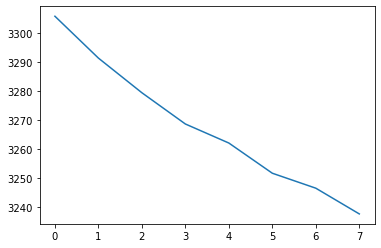

In [396]:
plt.plot([kmeans.inertia_ for kmeans in kmeans])

In [386]:
kmeans.inertia_

3291.4300122680625

In [397]:
clusters=[kmeans.labels_ for kmeans in kmeans]

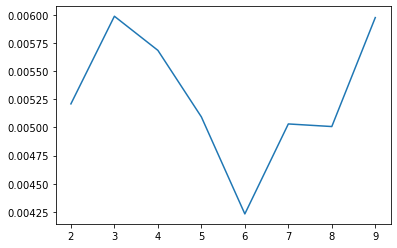

In [401]:
plt.plot(range(2,10),[silhouette_score(data,clusters) for clusters in clusters])

In [184]:
from collections import Counter

In [185]:
Counter(clusters)

Counter({1: 615, 0: 782, 3: 1480, 2: 510})

In [186]:
Counter(labels)

Counter({0: 799, 1: 973, 3: 628, 2: 987})

## Check what each clusters contains

In [188]:
cluster_label={i:labels[np.where(clusters==i)] for i in range(k)}

In [189]:
terms=tfidf_vector.get_feature_names()

/home/jake/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [190]:
centroids=kmeans.cluster_centers_

In [191]:
centroids.shape

(4, 13782)

In [192]:
for cluster,index_list in cluster_label.items():
    counter=Counter(cluster_label[cluster])
    print('cluster_{}: {} samples'.format(cluster,len(index_list)))
    for label_index, count in sorted(counter.items(), key=lambda x: x[1],reverse=True):
        print('\t{}: {} samples'.format(label_names[label_index],count))
        

cluster_0: 782 samples
	comp.graphics: 733 samples
	sci.space: 44 samples
	alt.atheism: 4 samples
	talk.religion.misc: 1 samples
cluster_1: 615 samples
	alt.atheism: 365 samples
	talk.religion.misc: 247 samples
	comp.graphics: 2 samples
	sci.space: 1 samples
cluster_2: 510 samples
	sci.space: 508 samples
	alt.atheism: 1 samples
	comp.graphics: 1 samples
cluster_3: 1480 samples
	sci.space: 434 samples
	alt.atheism: 429 samples
	talk.religion.misc: 380 samples
	comp.graphics: 237 samples


In [124]:
counter=Counter(cluster_label[0])

In [127]:
sorted(counter.items(), key=lambda x: x[1],reverse=True)

[(4, 53),
 (7, 52),
 (11, 52),
 (13, 48),
 (2, 45),
 (12, 44),
 (8, 44),
 (1, 44),
 (10, 42),
 (3, 42),
 (5, 39),
 (17, 38),
 (14, 36),
 (18, 35),
 (9, 34),
 (15, 31),
 (16, 30),
 (6, 28),
 (0, 23),
 (19, 18)]

In [117]:
Counter(cluster_label)

Counter({17: 38,
         19: 18,
         16: 30,
         4: 53,
         2: 45,
         5: 39,
         12: 44,
         7: 52,
         11: 52,
         9: 34,
         10: 42,
         8: 44,
         13: 48,
         3: 42,
         1: 44,
         18: 35,
         6: 28,
         15: 31,
         14: 36,
         0: 23})

## Encapsulate

In [199]:
from sklearn.pipeline import Pipeline

In [443]:
groups=fetch_20newsgroups(subset='all')
# ,categories=['alt.atheism','talk.religion.misc','comp.graphics','sci.space']
labels = groups.target
label_names = groups.target_names

data_cleaned=[]
for doc in groups.data:
    doc=doc.lower()
    doc_cleaned=' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word.isalpha() and word not in all_names)
    data_cleaned.append(doc_cleaned)

In [312]:
estimators=[('tfidf',TfidfVectorizer(stop_words='english',max_features=None,max_df=.5,min_df=2)),('kmeans',KMeans(n_clusters=k))]
pipeline = Pipeline(estimators)

In [313]:
data_pipe = pipeline.fit(data_cleaned)


In [326]:
data_pipe['tfidf'].transform(data_cleaned)

<3387x13782 sparse matrix of type '<class 'numpy.float64'>'
	with 222081 stored elements in Compressed Sparse Row format>

In [323]:
data_pipe['kmeans'].get_feature_names_out()

AttributeError: 'KMeans' object has no attribute 'get_feature_names_out'

In [315]:
data_pipe['kmeans'].labels_

array([3, 3, 0, ..., 2, 0, 0], dtype=int32)

In [240]:
len(data_cleaned)

3387

In [246]:
clusters=data_pipe['kmeans'].labels_

In [247]:
cluster_label={i:labels[np.where(clusters==i)] for i in range(k)}

In [248]:
terms=tfidf_vector.get_feature_names()

/home/jake/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [249]:
centroids=kmeans.cluster_centers_

In [250]:
for cluster,index_list in cluster_label.items():
    counter=Counter(cluster_label[cluster])
    print('cluster_{}: {} samples'.format(cluster,len(index_list)))
    for label_index, count in sorted(counter.items(), key=lambda x: x[1],reverse=True):
        print('\t{}: {} samples'.format(label_names[label_index],count))
        

cluster_0: 1471 samples
	alt.atheism: 495 samples
	talk.religion.misc: 388 samples
	sci.space: 376 samples
	comp.graphics: 212 samples
cluster_1: 568 samples
	sci.space: 565 samples
	alt.atheism: 1 samples
	talk.religion.misc: 1 samples
	comp.graphics: 1 samples
cluster_2: 541 samples
	alt.atheism: 300 samples
	talk.religion.misc: 238 samples
	comp.graphics: 2 samples
	sci.space: 1 samples
cluster_3: 807 samples
	comp.graphics: 758 samples
	sci.space: 45 samples
	alt.atheism: 3 samples
	talk.religion.misc: 1 samples


In [111]:
data.shape

(18846, 10)

## Tuning

In [306]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [444]:
estimators=[('tfidf',TfidfVectorizer(stop_words='english',max_features=None,max_df=.5,min_df=2)),('kmeans',KMeans(random_state=42))]
pipeline = Pipeline(estimators)

In [447]:
param_grid={"kmeans__n_clusters":np.arange(2,25)}

In [448]:
def scoring_silhouette(estimator,X):
    estimator.fit(X)
    cluster_labels=estimator['kmeans'].labels_
    cluster_vector=estimator['tfidf'].transform(X)
    
    return silhouette_score(cluster_vector,cluster_labels)

In [451]:
search=GridSearchCV(pipeline,param_grid=param_grid,cv=[(slice(None), slice(None))],scoring=scoring_silhouette,n_jobs=-1,verbose=4)

In [452]:
search.fit(data_cleaned)

Fitting 1 folds for each of 23 candidates, totalling 23 fits
[CV 1/1] END ..............kmeans__n_clusters=2;, score=0.002 total time= 1.7min
[CV 1/1] END ..............kmeans__n_clusters=3;, score=0.002 total time= 1.9min
[CV 1/1] END ..............kmeans__n_clusters=4;, score=0.003 total time= 2.3min
[CV 1/1] END ..............kmeans__n_clusters=5;, score=0.003 total time= 2.5min
[CV 1/1] END ..............kmeans__n_clusters=6;, score=0.003 total time= 2.9min
[CV 1/1] END ..............kmeans__n_clusters=7;, score=0.003 total time= 3.1min


In [441]:
search.cv_results_

{'mean_fit_time': array([2.85137439, 3.45610952, 4.06878591, 5.3998661 , 5.11998701,
        6.64615417, 6.56495237, 6.6083324 ]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([6.11449194, 6.12155032, 6.40112591, 6.21169734, 6.31498909,
        6.39213991, 6.12691712, 6.09070516]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_kmeans__n_clusters': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kmeans__n_clusters': 2},
  {'kmeans__n_clusters': 3},
  {'kmeans__n_clusters': 4},
  {'kmeans__n_clusters': 5},
  {'kmeans__n_clusters': 6},
  {'kmeans__n_clusters': 7},
  {'kmeans__n_clusters': 8},
  {'kmeans__n_clusters': 9}],
 'split0_test_score': array([0.00520835, 0.00598625, 0.00568341, 0.00509281, 0.0042315 ,
        0.00503018, 0.00500712, 0.00597438]),
 'mean_test_score': array([0.00520835,

In [347]:
search.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')),
                ('kmeans', KMeans(n_clusters=3))])

In [348]:
search.best_score_

0.006714867801979194

In [349]:
search.cv

{'kmeans__n_clusters': 3}

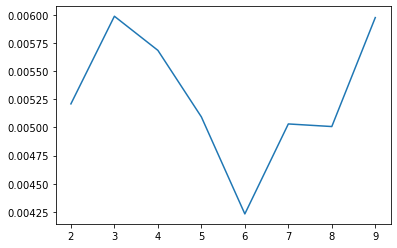

In [ ]:
plt.plot(param_grid['kmeans__n_clusters'],search.cv_results_['mean_test_score'])

## Evalution: 

In [251]:
from sklearn import metrics

In [252]:
l_t=[0,0,0,1,1,1]
l_p=[0,0,1,1,2,2]

In [254]:
metrics.rand_score(l_t,l_t)

1.0

In [257]:
metrics.adjusted_rand_score(l_t,l_p)

0.24242424242424243

In [78]:
data

<18846x10 sparse matrix of type '<class 'numpy.int64'>'
	with 56757 stored elements in Compressed Sparse Row format>

In [12]:
len(groups.data)

18846

In [28]:
mask,=np.where(groups.target==0)

In [34]:
print(groups.data[mask[-2]])

From: kempmp@phoenix.oulu.fi (Petri Pihko)
Subject: Re: Consciousness part II - Kev Strikes Back!
Organization: University of Oulu, Finland
X-Newsreader: TIN [version 1.1 PL9]
Lines: 30

Scott D. Sauyet (SSAUYET@eagle.wesleyan.edu) wrote:
> In <1993Apr21.163848.8099@cs.nott.ac.uk> 
> Kevin Anthony (kax@cs.nott.ac.uk) writes:

> > Firstly, I'm not impressed with the ability of algorithms. They're
> > great at solving problems once the method has been worked out, but not
> > at working out the method itself.
>   [ .. crossword example deleted ... ]

> Have you heard of neural networks?  I've read a little about them, and
> they seems to overcome most of your objections.

I'm sure there are many people who work with neural networks and
read this newsgroup. Please tell Kevin what you've achieved, and
what you expect.

> I am not saying that NNs will solve all such problems, but I think
> they show that it is not as hard as you think to come up with
> mechanical models of consciousness.

In

In [7]:
groups.filenames

array(['/home/jake/scikit_learn_data/20news_home/20news-bydate-test/rec.sport.hockey/54367',
       '/home/jake/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60215',
       '/home/jake/scikit_learn_data/20news_home/20news-bydate-train/talk.politics.mideast/76120',
       ...,
       '/home/jake/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       '/home/jake/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319',
       '/home/jake/scikit_learn_data/20news_home/20news-bydate-test/rec.autos/103195'],
      dtype='<U91')

In [9]:
print(groups.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [10]:
groups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
fetch_20newsgroups()

AttributeError: 'function' object has no attribute 'data_home'